In [1]:
import pandas as pd 
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_csv("Final_Dataset.csv")
df.head()

,Unnamed: 0,1007_s_at,1053_at,121_at,1294_at,1316_at,1405_i_at,1487_at,1494_f_at,1598_g_at,...,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,Age,Cancer,Normal,Positive
0,GSM246422,9.407554,5.565053,8.726430,8.019899,5.105877,5.703825,7.342717,6.525351,11.709236,...,9.295287,9.261067,11.481549,11.463537,13.074366,12.981368,46.0625,0,1,0
1,GSM246423,9.630196,5.672118,8.757641,8.216776,5.363880,5.345908,7.374830,6.380742,11.163090,...,8.382889,8.226192,11.035883,10.842324,12.913571,12.648306,46.0625,0,1,0
2,GSM246484,9.764252,5.427428,8.981097,8.129541,5.482619,5.497766,7.371828,6.775736,11.129177,...,8.059408,7.937681,10.825097,10.488385,12.459533,12.287843,46.0625,0,1,0
3,GSM246485,11.409979,6.367622,8.380824,8.604724,5.579678,6.158459,8.094469,6.730903,9.879993,...,9.351937,9.443774,11.706976,11.448037,13.059036,12.950919,27.0000,0,1,0
4,GSM246486,10.004760,6.159440,8.793381,7.821388,5.576516,6.740634,7.425016,6.966267,10.440405,...,9.427238,9.672939,11.488805,11.321471,13.004769,13.175343,38.0000,0,1,0


In [3]:
#selecting only those samples which are cancerous and have subtype as HPV(+ve) and HPV (-ve)
df1=df[df["Cancer"]==1]
df1.head()

,Unnamed: 0,1007_s_at,1053_at,121_at,1294_at,1316_at,1405_i_at,1487_at,1494_f_at,1598_g_at,...,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,Age,Cancer,Normal,Positive
24,GSM247650,10.161718,6.856963,7.831231,7.834324,5.540114,6.144347,7.704378,6.578718,9.831790,...,9.516064,9.350381,11.536460,11.160191,12.861077,12.794515,28.0,1,0,1
25,GSM247651,10.573239,6.300309,8.597096,8.083975,5.605117,6.810207,7.450964,6.851893,9.849331,...,9.239843,8.908166,11.785011,11.161178,13.080252,13.072573,55.0,1,0,1
26,GSM247652,10.375251,7.268768,8.295352,8.538916,5.384070,6.993762,8.234423,6.179563,9.167261,...,9.253786,8.975560,11.425723,11.305490,12.991434,12.804121,41.0,1,0,1
27,GSM247653,10.835008,6.251893,8.181855,7.906340,5.996190,5.963927,8.004590,7.105145,8.834594,...,10.023061,9.589047,12.469083,11.967948,13.484193,13.364423,62.0,1,0,1
28,GSM247654,11.270132,7.004911,8.271589,7.583673,5.616338,5.304531,8.255798,6.411326,8.963302,...,8.611658,8.385391,11.146927,11.241510,12.991647,12.619040,45.0,1,0,1


In [4]:
df1.drop(["Cancer","Normal"],axis=1,inplace=True)

C:\Users\amani\AppData\Local\Temp\ipykernel_27880\1326242256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(["Cancer","Normal"],axis=1,inplace=True)


In [5]:
l1=list(df1.columns)
l1[-1]="HPV"
l1[0]="ID"

In [6]:
df1.columns=l1

In [7]:
df1.head(3)

,ID,1007_s_at,1053_at,121_at,1294_at,1316_at,1405_i_at,1487_at,1494_f_at,1598_g_at,...,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,Age,HPV
24,GSM247650,10.161718,6.856963,7.831231,7.834324,5.540114,6.144347,7.704378,6.578718,9.831790,...,8.160644,8.253345,9.516064,9.350381,11.536460,11.160191,12.861077,12.794515,28.0,1
25,GSM247651,10.573239,6.300309,8.597096,8.083975,5.605117,6.810207,7.450964,6.851893,9.849331,...,7.720985,8.033950,9.239843,8.908166,11.785011,11.161178,13.080252,13.072573,55.0,1
26,GSM247652,10.375251,7.268768,8.295352,8.538916,5.384070,6.993762,8.234423,6.179563,9.167261,...,7.523849,8.013293,9.253786,8.975560,11.425723,11.305490,12.991434,12.804121,41.0,1


In [8]:
df1["HPV"].value_counts()

HPV
1    48
0     5
Name: count, dtype: int64

In [9]:
df1.head()

,ID,1007_s_at,1053_at,121_at,1294_at,1316_at,1405_i_at,1487_at,1494_f_at,1598_g_at,...,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,Age,HPV
24,GSM247650,10.161718,6.856963,7.831231,7.834324,5.540114,6.144347,7.704378,6.578718,9.831790,...,8.160644,8.253345,9.516064,9.350381,11.536460,11.160191,12.861077,12.794515,28.0,1
25,GSM247651,10.573239,6.300309,8.597096,8.083975,5.605117,6.810207,7.450964,6.851893,9.849331,...,7.720985,8.033950,9.239843,8.908166,11.785011,11.161178,13.080252,13.072573,55.0,1
26,GSM247652,10.375251,7.268768,8.295352,8.538916,5.384070,6.993762,8.234423,6.179563,9.167261,...,7.523849,8.013293,9.253786,8.975560,11.425723,11.305490,12.991434,12.804121,41.0,1
27,GSM247653,10.835008,6.251893,8.181855,7.906340,5.996190,5.963927,8.004590,7.105145,8.834594,...,8.727322,8.842855,10.023061,9.589047,12.469083,11.967948,13.484193,13.364423,62.0,1
28,GSM247654,11.270132,7.004911,8.271589,7.583673,5.616338,5.304531,8.255798,6.411326,8.963302,...,7.320685,7.332463,8.611658,8.385391,11.146927,11.241510,12.991647,12.619040,45.0,1


In [10]:
df1=df1.set_index("ID")

In [11]:
#standardization of the dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#separating dependent(y) and independent features(x)
X=df1.drop(["HPV","Age"],axis=1)
y=df1["HPV"]

# train-test-split 80-20 split after split 68-> train and 17->test
#total genes 9528

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)
print(f"Shape of X_train and y_train: {X_train.shape},{y_train.shape}")
print(f"Shape of X_test and y_test: {X_test.shape},{y_test.shape}")

Shape of X_train and y_train: (42, 9528),(42,)
Shape of X_test and y_test: (11, 9528),(11,)


In [12]:
#stanndardization
std=StandardScaler()
X_train_scaled=std.fit_transform(X_train) 
X_test_scaled=std.transform(X_test) # using transform method to prevent the data leakage 

In [13]:
#training the model

# 1. Random Forest Model

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)

rf_imp = rf.feature_importances_
rf_df = pd.DataFrame({'ID': X_train.columns, 'Importance': rf_imp}).sort_values(by='Importance', ascending=False)


In [14]:
rf_df.head(3)
rf_df=rf_df.set_index("ID")

In [16]:
df_gene=pd.read_csv("All_GENES_ID.csv")
df_gene=df_gene.set_index("ID")

In [17]:
rf_df_final=pd.merge(rf_df,df_gene,left_index=True,right_index=True)
rf_df_final=rf_df_final[rf_df_final["Importance"]!=0]

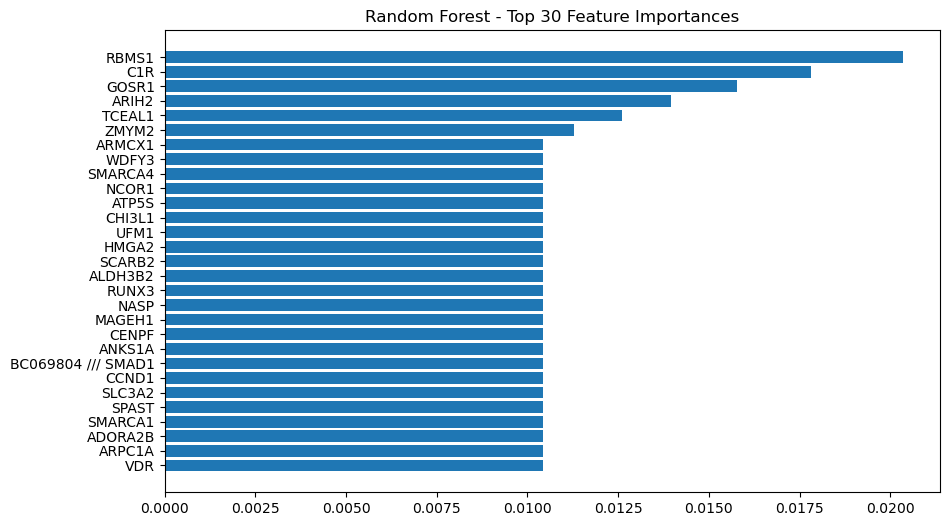

In [18]:
#visualizing
plt.figure(figsize=(10, 6))
plt.barh(rf_df_final['Gene Symbol'].head(30), rf_df['Importance'].head(30))
plt.title("Random Forest - Top 30 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [19]:
# 2. Lasso Logistic Regression based
import numpy as np

lasso = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000)
lasso.fit(X_train_scaled, y_train)

lasso_imp = np.abs(lasso.coef_[0])
lasso_df = pd.DataFrame({'ID': X_train.columns, 'Importance': lasso_imp}).sort_values(by='Importance', ascending=False)


In [20]:
lasso_df[:20]
lasso_df=lasso_df.set_index("ID")

In [21]:
lasso_df_final=pd.merge(lasso_df,df_gene,left_index=True,right_index=True)
lasso_df_final.head(10)

,Importance,Gene Symbol
ID,,
205794_s_at,0.642406,NOVA1
201380_at,0.511042,CRTAP
214012_at,0.507655,ERAP1
203394_s_at,0.429424,HES1
218694_at,0.325711,ARMCX1
204045_at,0.194108,TCEAL1
207943_x_at,0.147129,PLAGL1
41113_at,0.144469,ZNF500
204726_at,0.128127,CDH13


In [42]:
lasso_df_final['Gene Symbol'] = lasso_df_final['Gene Symbol'].astype(str).fillna("Unknown")
lasso_df_final[lasso_df_final["Importance"]>0]
lasso_df_final.to_csv("Lasso_results.csv")

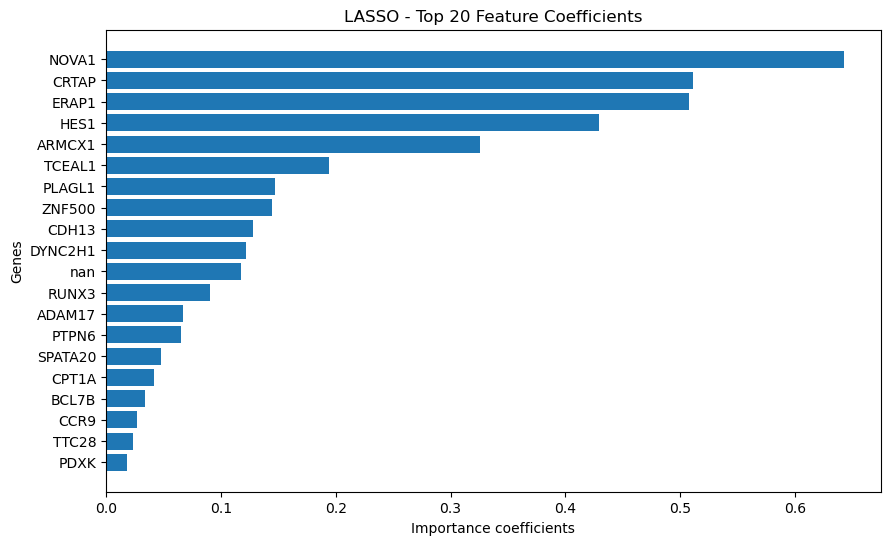

In [23]:

plt.figure(figsize=(10, 6))
plt.barh(lasso_df_final['Gene Symbol'].head(20), lasso_df_final['Importance'].head(20))
plt.title("LASSO - Top 20 Feature Coefficients")
plt.xlabel("Importance coefficients")
plt.ylabel("Genes")
plt.gca().invert_yaxis()
plt.show()

In [24]:
# 3. XGboost based implementation
pos_weight = (y_train == 0).sum() / (y_train == 1).sum() #represents the class imbalanceness
xgb_model = xgb.XGBClassifier(scale_pos_weight=pos_weight, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

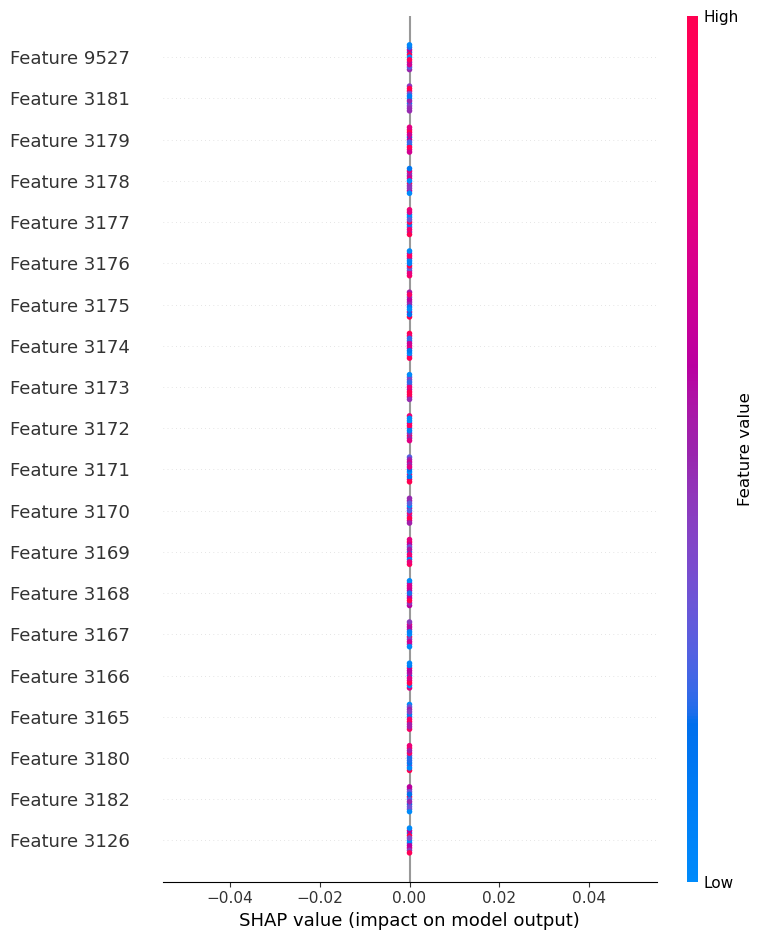

In [25]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled)


In [26]:
if isinstance(shap_values, list):
    shap_array = shap_values[1]  # or shap_values[0], depending on your use case
else:
    shap_array = shap_values

# Convert to DataFrame
shap_df = pd.DataFrame(shap_array, columns=X.columns)
feature_df = pd.DataFrame(X, columns=X.columns)

# Find features with highest SHAP value deviation
shap_std = shap_df.std().sort_values(ascending=False)
top_features = shap_std[shap_std > 0]

# Top N features
top_n = 15
top_feature_names = top_features.head(top_n).index.tolist()

# Display
print("Top deviating SHAP features:")
print(shap_df[top_feature_names].head())

Top deviating SHAP features:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [27]:
from xgboost import XGBClassifier
import pandas as pd

# Train your model
model = XGBClassifier()
model.fit(X_train_scaled, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns  # if X_train is a DataFrame

# Create DataFrame
importance_df_1 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df_1[:10]

,Feature,Importance
227,200718_s_at,0.174043
668,201227_s_at,0.172866
1651,202518_at,0.167608
4822,210282_at,0.153566
7507,218019_s_at,0.090067
6836,215095_at,0.083385
6931,215528_at,0.070373
2645,204045_at,0.053170
3088,205006_s_at,0.034923
6358,213655_at,0.000000


In [28]:
importance_df_1=importance_df_1.set_index("Feature")

In [29]:
#with booster
# Step 1: Get feature importances from booster
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')  # or 'weight', etc.

# Step 2: Create mapping from 'f0', 'f1', ... to actual column names
feature_map = {f'f{i}': name for i, name in enumerate(X_train.columns)}

# Step 3: Convert to DataFrame and map names
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['Importance'])
importance_df.index.name = 'Feature'
importance_df = importance_df.reset_index()
importance_df['Feature'] = importance_df['Feature'].map(feature_map)
importance_df = importance_df.sort_values(by='Importance', ascending=False)


In [30]:

final_xgb=pd.merge(importance_df,df_gene,left_index=True,right_index=True)

,Feature,Importance,Gene Symbol


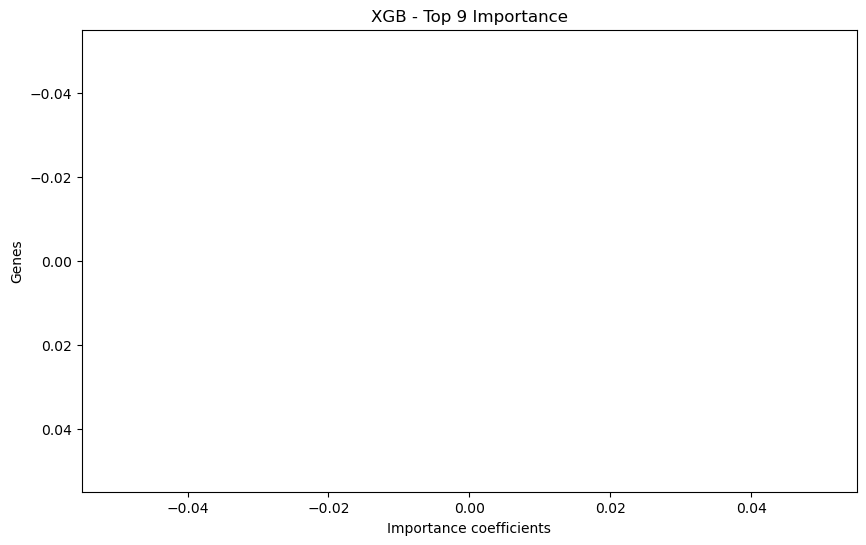

In [31]:
final_xgb['Gene Symbol'] = final_xgb['Gene Symbol'].astype(str).fillna("Unknown")
plt.figure(figsize=(10, 6))
plt.barh(final_xgb['Gene Symbol'].head(15), final_xgb['Importance'].head(15))
plt.title("XGB - Top 9 Importance")
plt.xlabel("Importance coefficients")
plt.ylabel("Genes")
plt.gca().invert_yaxis()
plt.show()

In [32]:
#direct score without the booster
final_xgb_1=pd.merge(importance_df_1,df_gene,left_index=True,right_index=True)

In [45]:
final_xgb_1[final_xgb_1["Importance"]>0]

,Importance,Gene Symbol
200718_s_at,0.174043,SKP1
201227_s_at,0.172866,NDUFB8
202518_at,0.167608,BCL7B
210282_at,0.153566,ZMYM2
218019_s_at,0.090067,PDXK
215095_at,0.083385,nan
215528_at,0.070373,nan
204045_at,0.053170,TCEAL1
205006_s_at,0.034923,NMT2


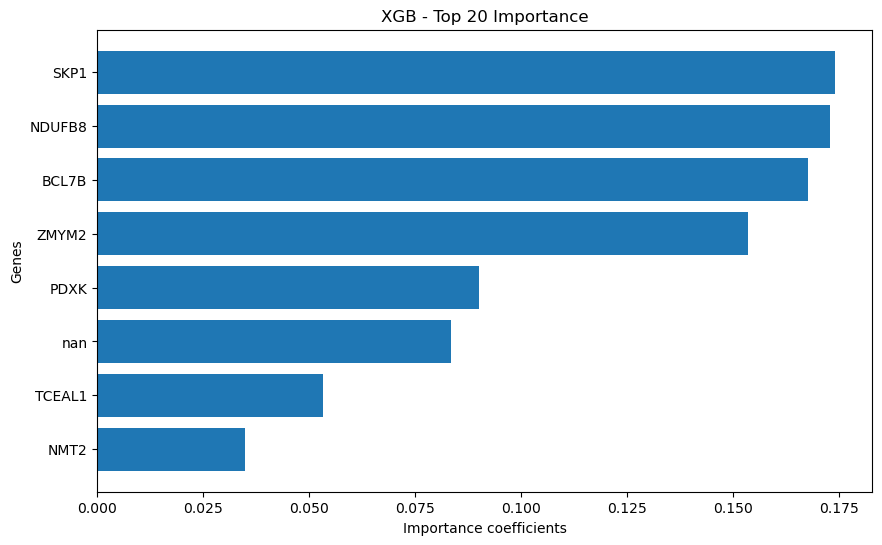

In [33]:
final_xgb_1['Gene Symbol'] = final_xgb_1['Gene Symbol'].astype(str).fillna("Unknown")
plt.figure(figsize=(10, 6))
plt.barh(final_xgb_1['Gene Symbol'].head(9), final_xgb_1['Importance'].head(9))
plt.title("XGB - Top 20 Importance")
plt.xlabel("Importance coefficients")
plt.ylabel("Genes")
plt.gca().invert_yaxis()
plt.show()

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print(f"\n==== {name} Performance ====")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC-AUC  :", roc_auc_score(y_test, y_proba))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# === Run for all models ===
evaluate_model("Random Forest", rf, X_test_scaled, y_test)
evaluate_model("LASSO Logistic Regression", lasso, X_test_scaled, y_test)
evaluate_model("XGBoost", xgb_model, X_test_scaled, y_test)


==== Random Forest Performance ====
Accuracy : 0.9090909090909091
Precision: 0.9090909090909091
Recall   : 1.0
F1 Score : 0.9523809523809523
ROC-AUC  : 0.45

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.91      1.00      0.95        10

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11

Confusion Matrix:
[[ 0  1]
 [ 0 10]]

==== LASSO Logistic Regression Performance ====
Accuracy : 0.8181818181818182
Precision: 0.9
Recall   : 0.9
F1 Score : 0.9
ROC-AUC  : 0.7

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      0.90      0.90        10

    accuracy                           0.82        11
   macro avg       0.45      0.45      0.45        11
weighted avg       

c:\Users\amani\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\amani\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


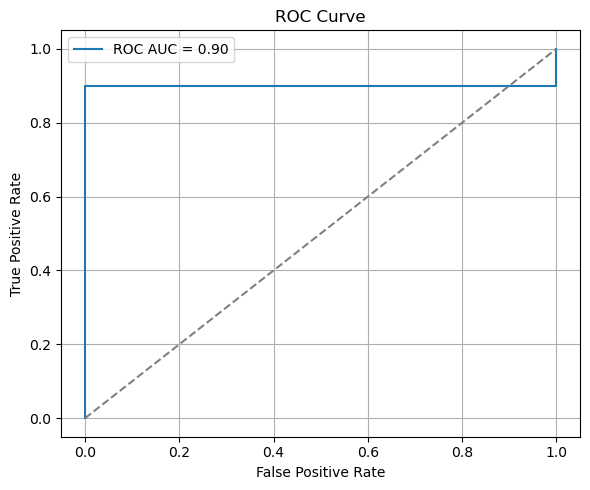

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
y_scores = lasso.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

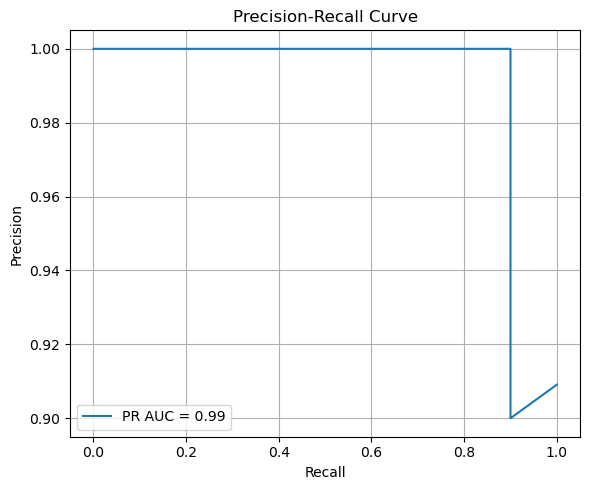

In [36]:
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=cv, scoring='f1')
print("F1 CV mean:", scores.mean())

F1 CV mean: 0.9503759398496239


In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso, X, y, cv=cv, scoring='f1')
print("F1 CV mean:", scores.mean())

F1 CV mean: 0.8945697577276525


In [39]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='f1')
print("F1 CV mean:", scores.mean())

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Fitting model on training data
rf.fit(X_train_scaled, y_train)

# Predicting on training data
y_train_pred = rf.predict(X_train_scaled)

# Calculating training accuracy
train_acc = accuracy_score(y_train, y_train_pred)

# Calculating training F1 score (macro, micro, or weighted depending on your problem)
train_f1 = f1_score(y_train, y_train_pred, average='micro')  # or 'micro' or 'weighted'

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Training F1 Score: {train_f1 * 100:.2f}%")

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Fitting model on training data
xgb_model.fit(X_train_scaled, y_train)

# Predicting on training data
y_train_pred = xgb_model.predict(X_train_scaled)

# Calculating training accuracy
train_acc = accuracy_score(y_train, y_train_pred)

# Calculating training F1 score (macro, micro, or weighted depending on your problem)
train_f1 = f1_score(y_train, y_train_pred, average='micro')  # or 'micro' or 'weighted'

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Training F1 Score: {train_f1 * 100:.2f}%")

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Fitting model on training data
lasso.fit(X_train_scaled, y_train)

# Predicting on training data
y_train_pred = lasso.predict(X_train_scaled)

# Calculating training accuracy
train_acc = accuracy_score(y_train, y_train_pred)

# Calculating training F1 score (macro, micro, or weighted depending on your problem)
train_f1 = f1_score(y_train, y_train_pred, average='micro')  # or 'micro' or 'weighted'

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Training F1 Score: {train_f1 * 100:.2f}%")

In [ ]:
rf_df_final.to_csv("RF_results.csv")